# Visualize Hex2Vec Embeddings
In this notebook we visualize our hex2vec encodings using clusterings and principal component analysis.

In [1]:
%load_ext autoreload
%autoreload 2
# %autoawait asyncio

In [2]:
%cd ..

d:\hex2vec2


## Load data
Here we load the encodings and also the OpenStreetMap data. The hex2vec model measures similarity using the cosine similarity, but most clustering algorithms use the euclidian distance measure. We therefore normalize the encodings, because this leads to both measures having the same results.

In [5]:
import pandas as pd
from src.settings import DATA_EMBEDDED_DIR
from sklearn.preprocessing import normalize

In [6]:
embedded_df = pd.read_feather(DATA_EMBEDDED_DIR.joinpath("embedded_9_12.05-2"))
embedded_df.set_index("h3", inplace= True)
df = pd.read_feather(DATA_EMBEDDED_DIR.joinpath("df_9_12.05-2"))
df.set_index("h3", inplace= True)
norm_df = pd.DataFrame(normalize(embedded_df), index = embedded_df.index)

## Clustering
We are using agglomerative clustering with a varying number of clusters

In [7]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from src.data.make_dataset import h3_to_polygon
import geopandas as gpd

In [8]:
cluster_df = df.copy(deep=False)

In [9]:
# Agglomerative Clustering normalized
for number_clusters in range(3, 12):
    cluster_agg = AgglomerativeClustering(n_clusters=number_clusters, linkage='ward')
    cluster_df[f'label_agg_norm_{number_clusters}'] = cluster_agg.fit_predict(norm_df)

## Visualize Clusterings

In [12]:
from src.analytics.analytics import cluster_difference, explain_cluster, cluster_sizes
from src.analytics.visualization import plot_map

In [11]:
cluster_df['geometry'] = cluster_df.index.map(h3_to_polygon)

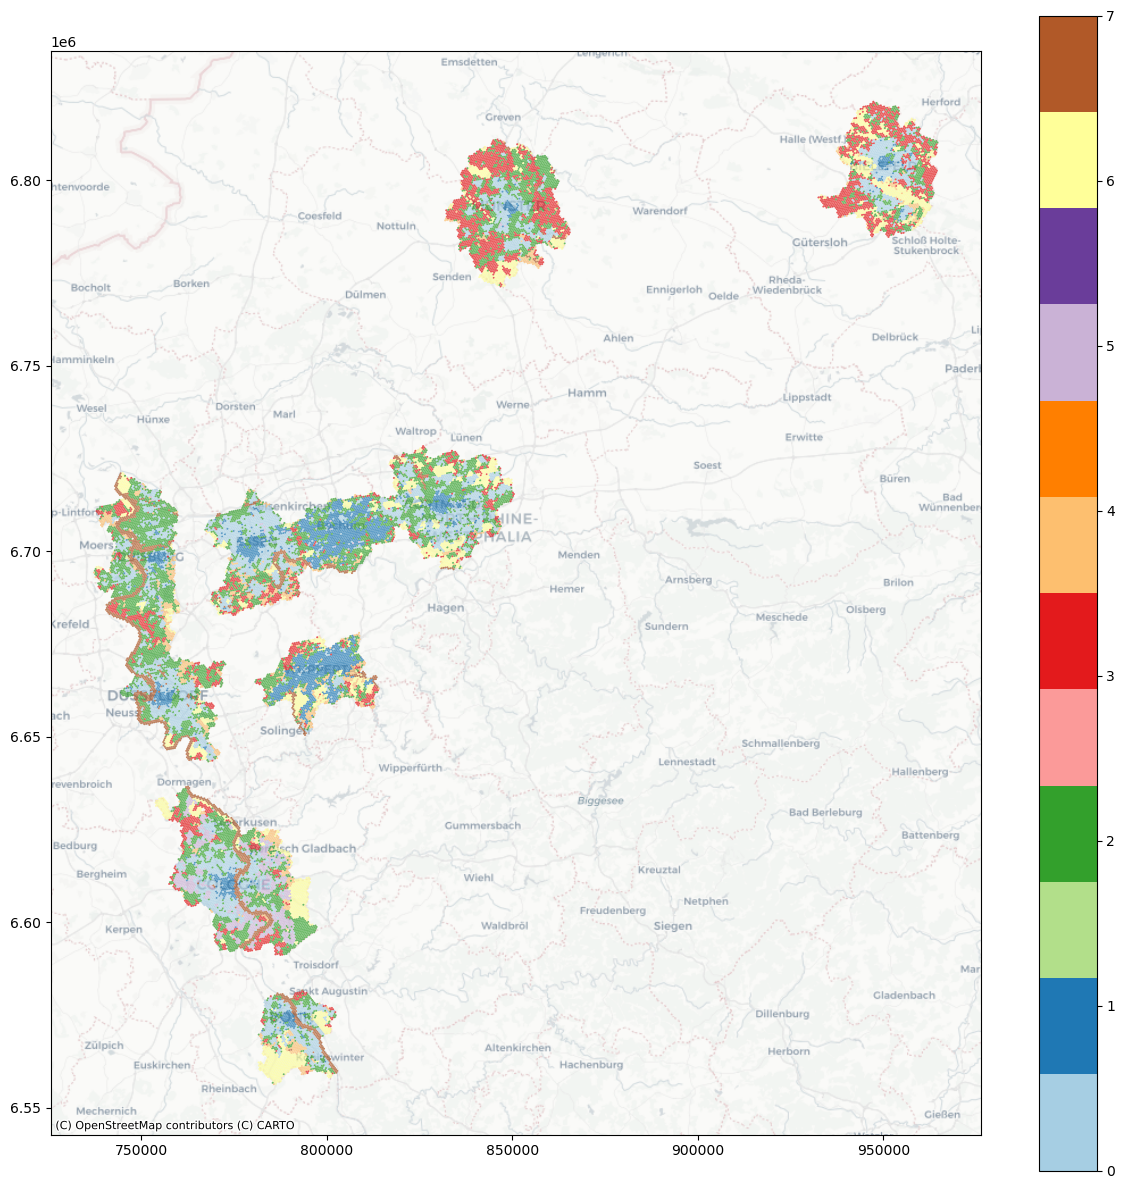

In [13]:
plot_map(cluster_df, "label_agg_norm_8", colors = "Paired")

In [21]:
# this function shows which tags are used in cluster 1 much more often than in cluster 3
cluster_difference(cluster_df, 1, 3 , label = "label_agg_norm_8", all_tags = df.columns)

shop_clothes           815.906181
building_apartments    393.659301
building_office        331.565673
tourism_artwork        231.577664
amenity_doctors        194.012969
                          ...    
natural_water            0.668568
landuse_meadow           0.304637
landuse_farmyard         0.073766
ditch                    0.061775
landuse_farmland         0.038584
Length: 62, dtype: float64

In [17]:
# this function returns those tags that are used much more/less often than in other clusters
explain_cluster(cluster_df, 1, label = "label_agg_norm_8", ascending = True, all_tags = df.columns)

landuse_meadow                  0.574862
natural_water                   0.588447
building_semidetached_house     0.729522
waterway_stream                 0.859776
landuse_forest                  1.039435
                                 ...    
garages                        10.940679
amenity_telephone              11.966763
historic_memorial              13.641896
leisure_garden                 16.501072
shop_clothes                   20.963621
Length: 64, dtype: float64

In [183]:
# the following code was used to get all hexagons of certain clusters but without getting 
# "islands" (hexagons with no neighbours) to use again for training hex2vec.
# See df_urban in train-hex2vec.ipynb

# import h3 
# from src.settings import DATA_PROCESSED_DIR

# urban_indices = set(cluster_df[cluster_df.label_agg_norm_4 == 0].index)
# urban_indices_reduced = urban_indices.copy()

# changed = True
# while changed:
#     changed = False
#     urban_indices = urban_indices_reduced.copy()
#     for index in urban_indices:
#         available_neighbours = h3.k_ring(index, 1).intersection(urban_indices_reduced)
#         if len(available_neighbours) < 3:
#             changed = True
#             urban_indices_reduced.remove(index)

# urban_indices_reduced = pd.DataFrame(urban_indices_reduced, columns = ["indices"])

# urban_indices_reduced.to_feather(
#         DATA_PROCESSED_DIR.joinpath("urban_indices.feather")
#     )

## Principal Component Analysis
Here we use PCA to visualize the embedding using red, green and blue.

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from src.data.make_dataset import h3_to_polygon

In [19]:
pca = PCA(3)
pca_embeddings = pca.fit_transform(embedded_df)

rgb = MinMaxScaler().fit_transform(pca_embeddings)

pca_df = df.copy(deep=False)
pca_df['geometry'] = pca_df.index.map(h3_to_polygon)

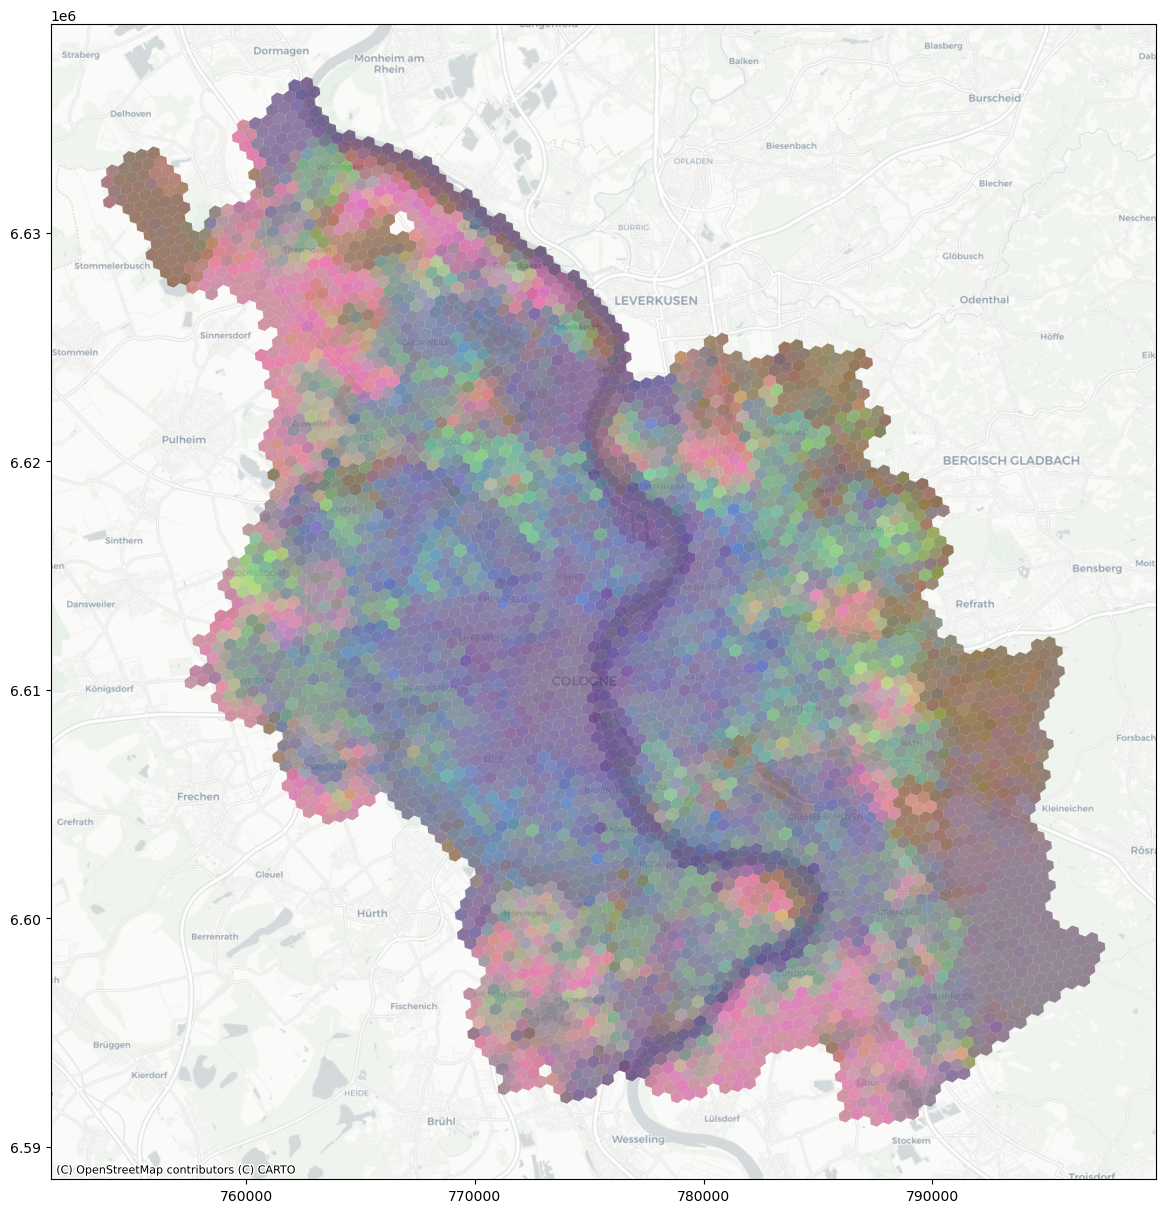

In [20]:
cgn_pca_df = pca_df[pca_df["city"] == "Cologne, Germany"]
plot_map(cgn_pca_df, colorscheme = rgb)